In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# Split the training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [4]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_val.shape)
print('Validation Labels Shape: ', y_val.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (40000, 32, 32, 3)
Train Labels Shape:       (40000, 1)

Validation Images Shape:  (10000, 32, 32, 3)
Validation Labels Shape:  (10000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


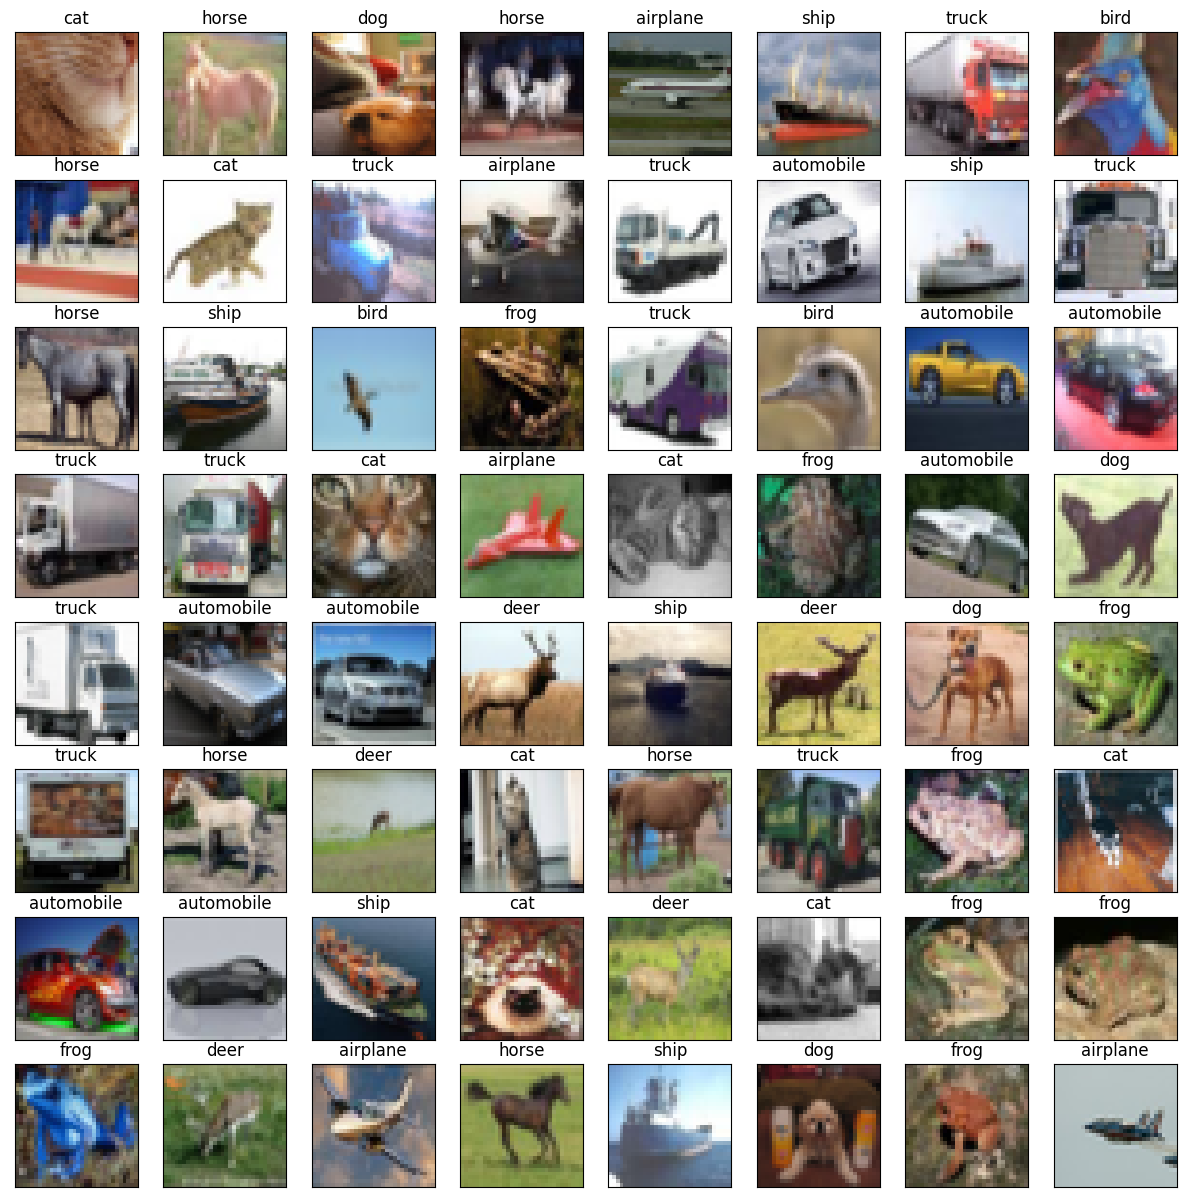

In [5]:
# CIFAR-10 classes
lables = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_train[i])

    # Set the label as the title
    plt.title(lables[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

Text(0.5, 1.0, 'Class distribution in training set')

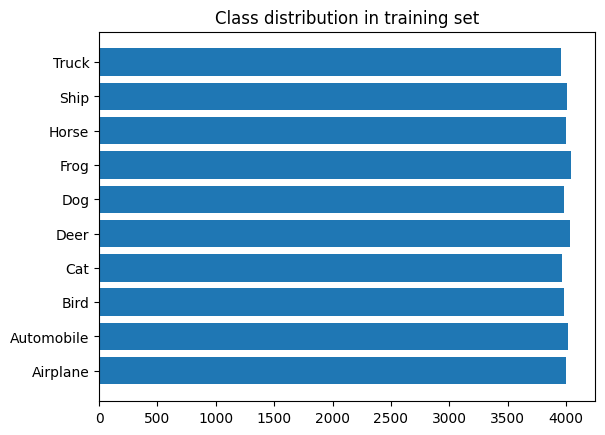

In [6]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

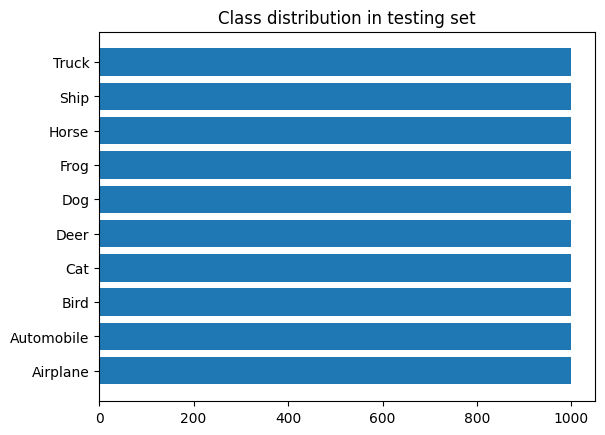

In [7]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

In [8]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (40000, 32, 32, 3)
X_val shape: (10000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)


In [9]:
# Transform target variable into one-hotencoding
y_category_train = to_categorical(y_train, 10)
y_category_val = to_categorical(y_val, 10)
y_category_test = to_categorical(y_test, 10)

In [10]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [11]:
data_generator = ImageDataGenerator(
    width_shift_range=0.1,

    rotation_range=10,

    # zoom_range=0.1,

    # brightness_range=[0.9,1.1],

    # shear_range=10,

    # channel_shift_range=0.1,

    height_shift_range=0.1, 

    horizontal_flip=True    
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [12]:
batch_size = 32
train_generator = data_generator.flow(X_train, y_category_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

Eval = model.fit(train_generator, 
                 epochs=50,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=(X_val, y_category_val), 
                 callbacks=[early_stop]
               )

Epoch 1/50
1250/1250 [==============================] - 136s 106ms/step - loss: 1.6771 - accuracy: 0.3932 - precision: 0.5940 - recall: 0.1752 - val_loss: 1.6008 - val_accuracy: 0.4296 - val_precision: 0.5370 - val_recall: 0.3141
Epoch 2/50
1250/1250 [==============================] - 135s 108ms/step - loss: 1.3161 - accuracy: 0.5329 - precision: 0.7056 - recall: 0.3543 - val_loss: 1.1248 - val_accuracy: 0.6012 - val_precision: 0.7337 - val_recall: 0.4810
Epoch 3/50
1250/1250 [==============================] - 132s 106ms/step - loss: 1.1215 - accuracy: 0.6052 - precision: 0.7519 - recall: 0.4589 - val_loss: 1.4337 - val_accuracy: 0.5400 - val_precision: 0.6873 - val_recall: 0.4394
Epoch 4/50
1250/1250 [==============================] - 132s 106ms/step - loss: 1.0183 - accuracy: 0.6503 - precision: 0.7774 - recall: 0.5219 - val_loss: 1.0063 - val_accuracy: 0.6841 - val_precision: 0.7702 - val_recall: 0.6046
Epoch 5/50
1250/1250 [==============================] - 134s 107ms/step - loss: 

313/313 [==============================] - 6s 19ms/step - loss: 0.4170 - accuracy: 0.8603 - precision: 0.8960 - recall: 0.8318
Test Accuracy : 86.03%
313/313 [==============================] - 6s 19ms/step


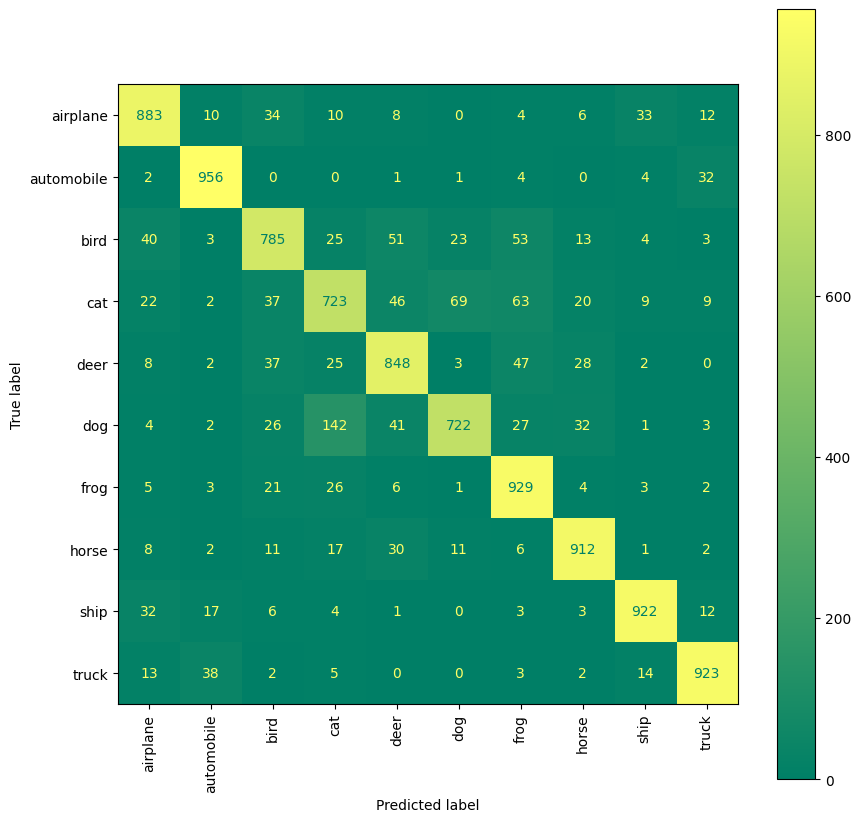

In [13]:
evaluation = model.evaluate(X_test, y_category_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lables)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1000
           1       0.92      0.96      0.94      1000
           2       0.82      0.79      0.80      1000
           3       0.74      0.72      0.73      1000
           4       0.82      0.85      0.83      1000
           5       0.87      0.72      0.79      1000
           6       0.82      0.93      0.87      1000
           7       0.89      0.91      0.90      1000
           8       0.93      0.92      0.93      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



 Image 50 is [9]
1/1 [==============================] - 0s 26ms/step
The model predict that image 50 is 9


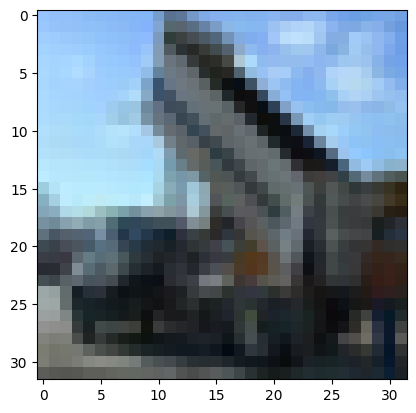

In [15]:
my_image = X_test[50]
plt.imshow(my_image)

# that's a Deer
print(f" Image 50 is {y_test[50]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 50 is {pred_100}")

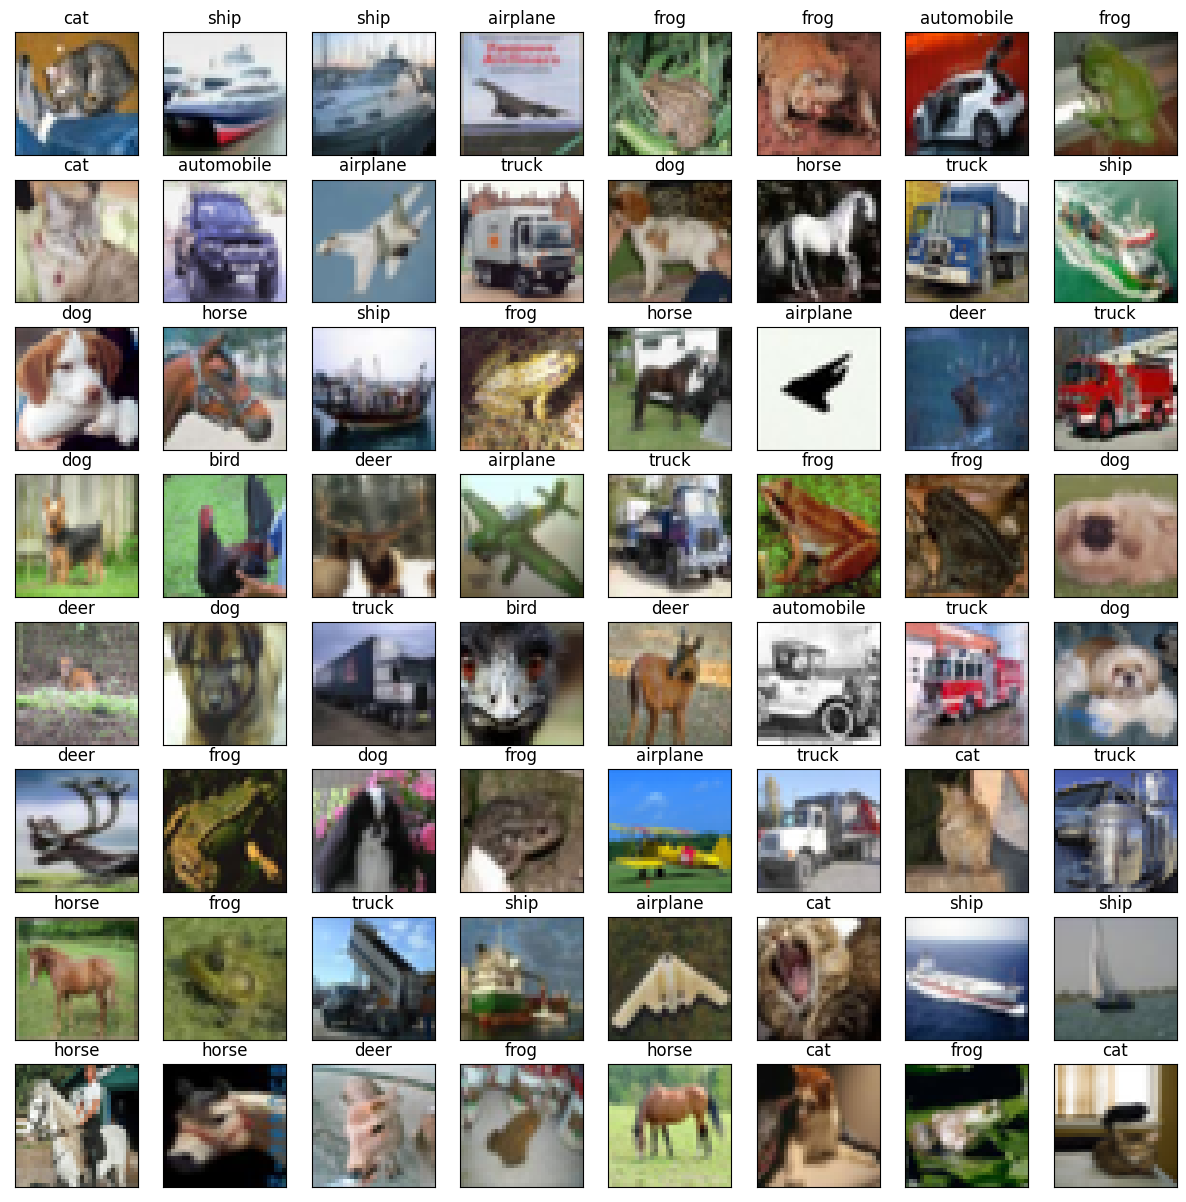

In [16]:
# CIFAR-10 classes
lables = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    # Create a subplot for each image
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(X_test[i])

    # Set the label as the title
    plt.title(lables[y_test[i][0]], fontsize=12)

# Display the figure
plt.show()

In [17]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{lables[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({lables[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 7s 22ms/step


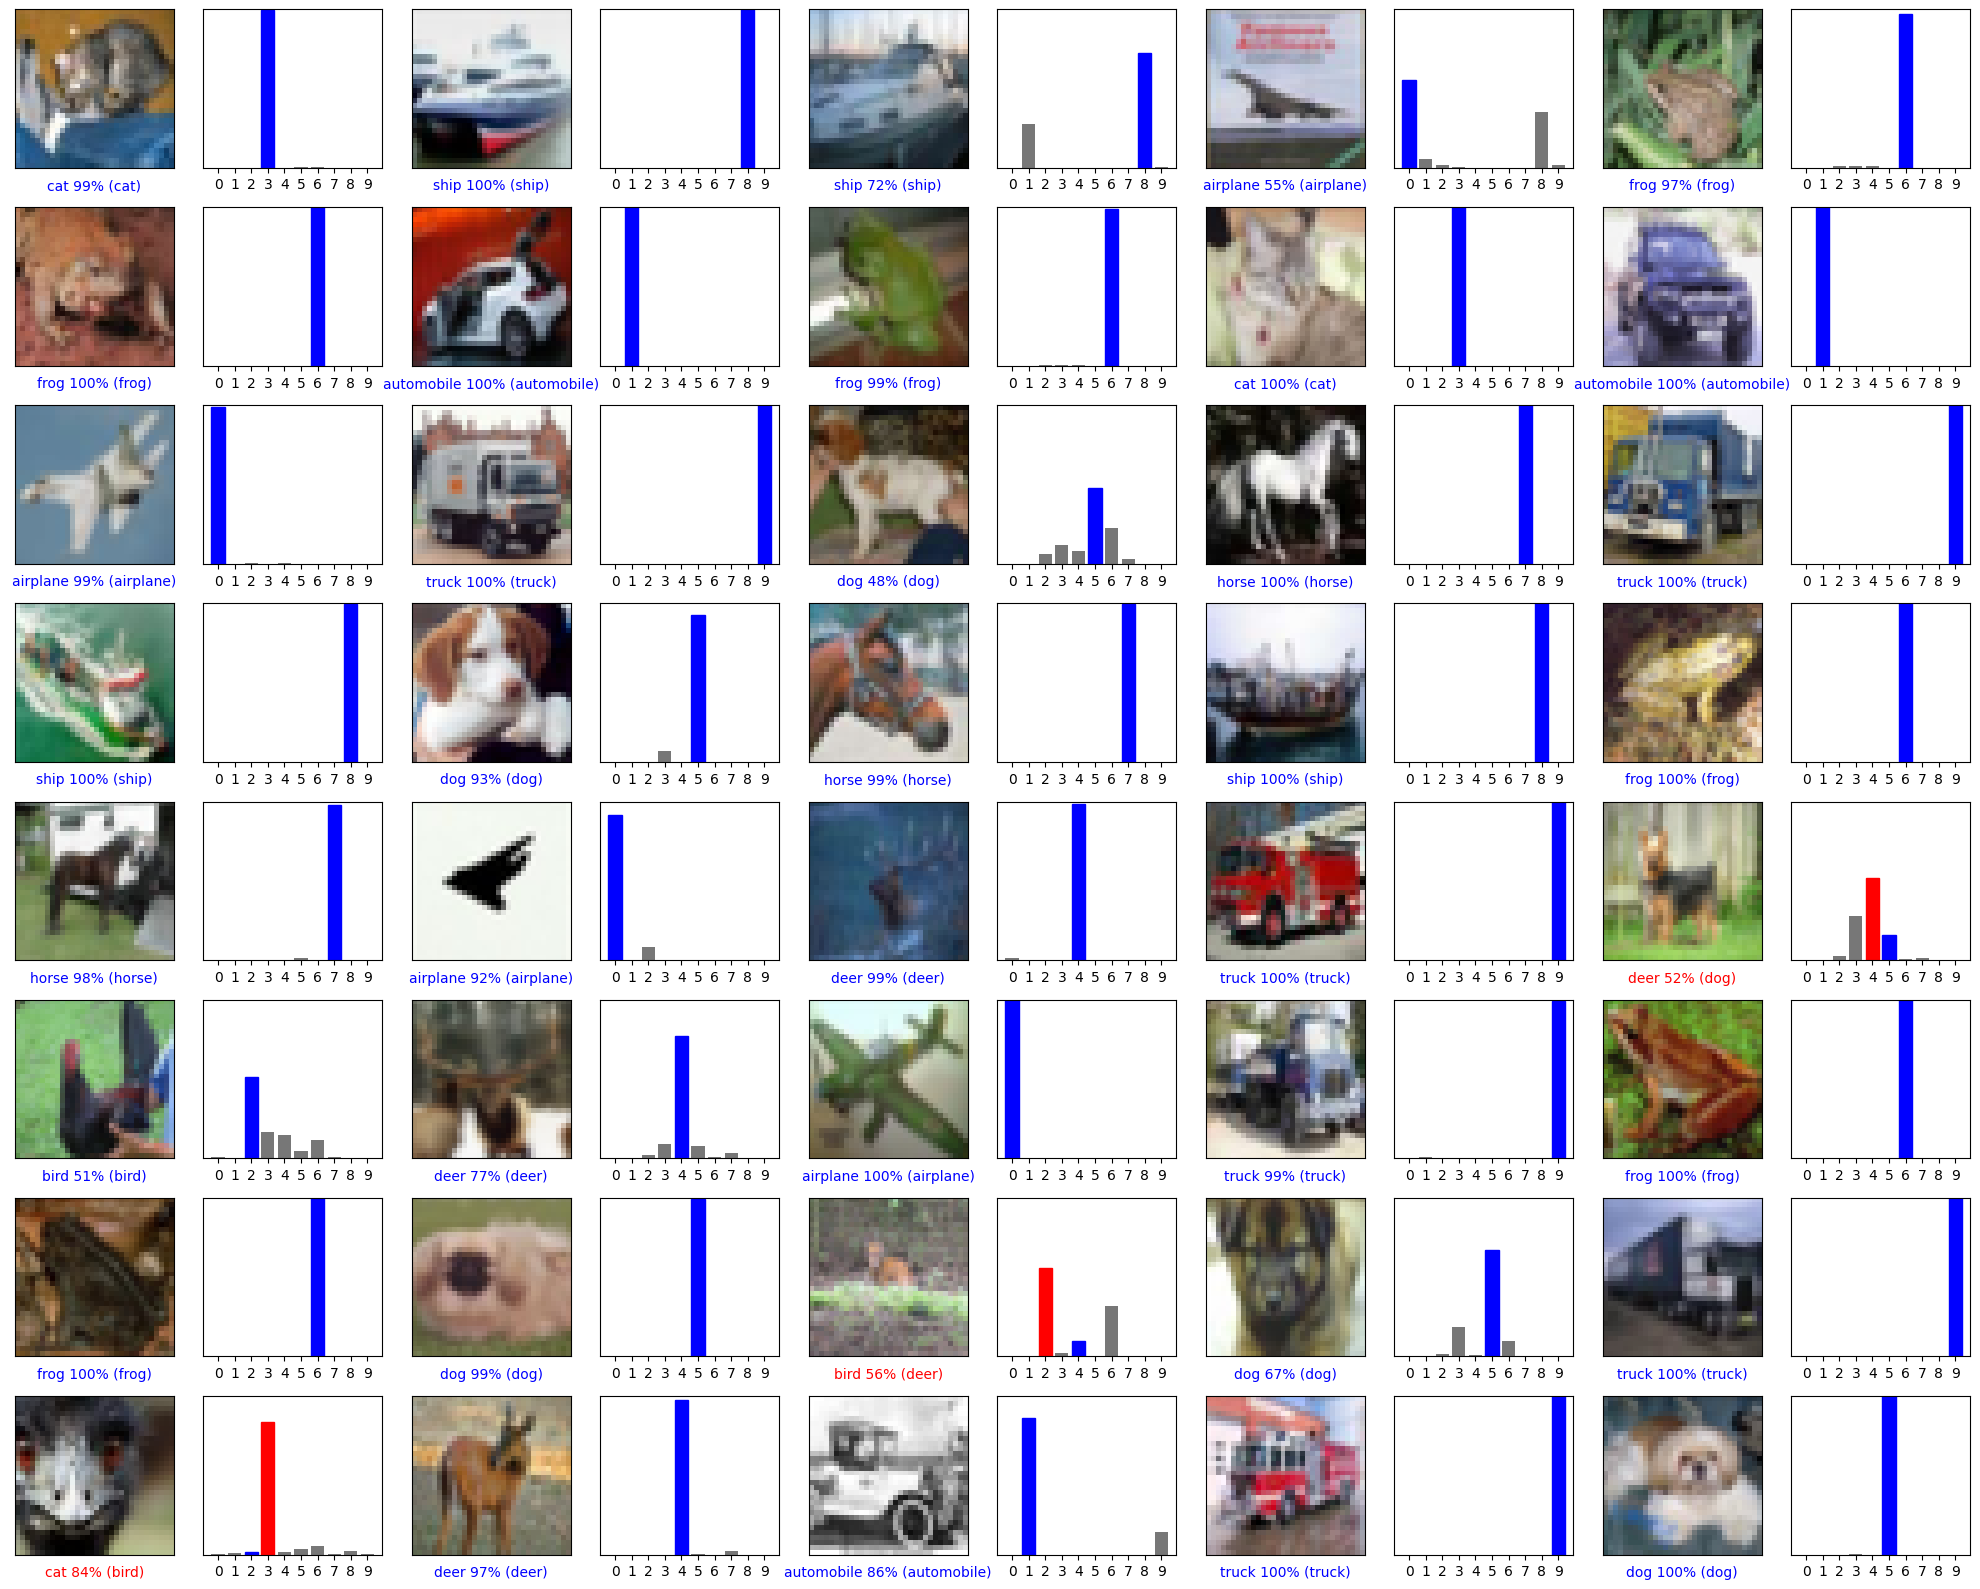

In [18]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [19]:
model.save('cnn_20_epochs.h5')